# Import libraries



In [52]:
from sklearn import preprocessing
from skimage.io import imread
from skimage import io
from skimage.transform import rescale
import os
import time
import numpy as np
from tqdm import tqdm
%matplotlib inline
from matplotlib import pyplot as plt
from DICTOL_python.dictol.utils import randperm
from DICTOL_python.dictol.utils import label_to_range
from DICTOL_python.dictol.utils import get_block_col
from DICTOL_python.dictol.utils import normc
from DICTOL_python.dictol import SRC, DLSI

# Load Hand_Gesture_Recognition_Database and Compute feature vectors

In [53]:
scale_factor = 0.25

In [54]:
# Find out image dimension (it is assumed that all images have the same size)
# Read image
im_path = 'DICTOL_python/dictol/data/Hand Gesture Recognition Database/05_thumb/frame_00_05_0008.png'
im = imread(im_path)
im = rescale(im, scale_factor)
print(f'Image size: {im.shape}')

Image size: (60, 160)


In [55]:
# Random projection class
class RP:

    ### Constractor.
    # Save hyper parameters as member variables.
    # Create random matrix generator and random matrix instance.
    def __init__(self, dim_in, dim_out):
        self.dim_in = dim_in
        self.dim_out = dim_out
        # Normalized random Gaussian matrix
        self.proj_mat = np.sqrt(dim_out) * np.random.randn(dim_in, dim_out)  #np.sqrt(dim_out) normalizes every column to 1

    ### Compute random projections over X, where every row is data sample.
    def compute_rp(self, X):
        rp_feat = X @ self.proj_mat
        return rp_feat

In [59]:
# Main function to load Hand_Gesture_Recognition_Database and compute compressed features
def load_HGR_train_test(N_train_c, dim_feat=504, subsampling=[], scale_factor=1):
    # Arguments
    # - N_train_c: number of training images per class to learn/build dictionary.
    # - dim_feat: dimensionality of the random projected vectors.
    # - subsampling: reduce the number of samples in database using this subsampling factor.
    # - scale_factor: image scaling factor.

    # Read images from database and generate feature vectors
    path_list = []
    label_list = []
    dataset_path = os.path.abspath('DICTOL_python/dictol/data/Hand Gesture Recognition Database')
    for path, dirs, files in os.walk(dataset_path):
        # In Linux and Mac, os.walk() returns an unordered list of files and directories
        dirs.sort()
        print(f'Scanning folder: {os.path.dirname(os.path.abspath(os.path.join(path, files[0])))}')
        for file in sorted(files):
            if file.endswith(".png"):
                # Add image to path list
                path_list.append(os.path.join(path, file))

                # Estimate labels from folder names
                full_path = os.path.dirname(os.path.abspath(os.path.join(path, file)))
                label = os.path.normpath(full_path).split(os.path.sep)[-1]
                label_list.append(label)

    if subsampling:
      total_samples = len(path_list)
      num_samples = int(subsampling/100*total_samples)
      ind = np.random.permutation(total_samples)
      path_list = [path_list[i] for i in ind[:num_samples]]
      label_list = [label_list[i] for i in ind[:num_samples]]
      print(f'Subsampling database. Num of considered samples: {num_samples} out of {total_samples} ({subsampling}%)')

    feat_list = []
    rp = []
    count = 0
    progress_bar = tqdm(path_list)
    for im_path in progress_bar:
        # Computes feature vectors (RP) from images
        # Read image
        im = imread(im_path)
        im = rescale(im, scale_factor)
        im = (im/255)-0.5
        im_vec = im.reshape((1, -1))
        # Computes feature vector
        if not rp:
            rp = RP(dim_in=im_vec.shape[1], dim_out=dim_feat)
        rp_feat = rp.compute_rp(im_vec)
        feat_list.append(rp_feat)

        count = count + 1
        progress_bar.set_description(f"Processed {count} samples")

    Y = np.asarray(feat_list).squeeze().transpose()
    # Label enconding
    le = preprocessing.LabelEncoder()
    le.fit(label_list)
    label_int = le.transform(label_list) + 1  # Function label_to_range() requires that labels start by 1 (not 0)
    # Decoding: le.inverse_transform(label_int)

    # Order label_int and path_list as required by label_to_range()
    if subsampling:
      ord_ind = sorted(range(len(label_int)), key=lambda k: label_int[k])
      label_int = [label_int[i] for i in ord_ind]
      path_list = [path_list[i] for i in ord_ind]

    d = Y.shape[0]  # Size of feature vectors computed from images.
    Y_range = np.array(label_to_range(label_int))

    C = Y_range.size - 1
    N_total = Y_range[-1]
    N_train = C * N_train_c
    N_test = N_total - N_train
    if (N_test <= 0):
      print(f'Number of samples: {N_total}')
      print(f'Number of training samples: {N_train}')
      print(f'Number of training samples: {N_test}')
      raise Exception("Too many samples in the training subset. There in not enough for testing. Reduce the value of variable N_train_c.")

    Y_train = np.zeros((d, N_train))
    Y_test = np.zeros((d, N_test))
    label_train = [0] * N_train
    label_test = [0] * N_test
    cur_train = 0
    cur_test = 0
    for c in range(C):
        Yc = get_block_col(Y, c, Y_range)
        N_total_c = Yc.shape[1]
        N_test_c = N_total_c - N_train_c
        if (N_test_c <= 0):
          print(f'Number of samples for class {le.inverse_transform(c)}: {N_total_c}')
          print(f'Number of training samples for class {le.inverse_transform(c)}: {N_train_c}')
          print(f'Number of testing samples for class {le.inverse_transform(c)}: {N_test_c}')
          str_0 = f"Too many samples in the training subset for the class {le.inverse_transform(c)}.  There in not enough for testing. Reduce the value of variable N_train_c."
          raise Exception(str_0)
        label_train[cur_train: cur_train + N_train_c] = [c + 1] * N_train_c
        label_test[cur_test:cur_test + N_test_c] = [c + 1] * N_test_c

        ids = randperm(N_total_c)

        Y_train[:, cur_train: cur_train + N_train_c] = \
            Yc[:, np.sort(ids[:N_train_c])]

        Y_test[:, cur_test: cur_test + N_test_c] = \
            Yc[:, np.sort(ids[N_train_c:])]

        cur_train += N_train_c
        cur_test += N_test_c

    Y_train = normc(Y_train)
    Y_test = normc(Y_test)
    return (Y_train, label_train, Y_test, label_test, le, rp)

In [60]:
N_train = 200  # Training images per class to build dictionary. Total training samples: N_train x Num classes
dim_feat = 1500  # Dimension of the image feature vectors
subsampling = []  # Percentage for subsampling the database sample and speed up the computational time. [] for use all samples

start = time.time()
Y_train, label_train, Y_test, label_test, le, rp = load_HGR_train_test(N_train, dim_feat=dim_feat, subsampling=subsampling, scale_factor=scale_factor)
end = time.time()

print(f'Elapse time for loading dataset and feature computation (s): {end - start}')
print(f'Num training images: {Y_train.shape[1]}')
print(f'Num test images: {Y_test.shape[1]}')
print(f'Class ids: {set(label_train)}')

Scanning folder: /home/dfc/projects/classes/bdivs/lab6/data/DICTOL_python/dictol/data/Hand Gesture Recognition Database
Scanning folder: /home/dfc/projects/classes/bdivs/lab6/data/DICTOL_python/dictol/data/Hand Gesture Recognition Database/01_palm
Scanning folder: /home/dfc/projects/classes/bdivs/lab6/data/DICTOL_python/dictol/data/Hand Gesture Recognition Database/02_l
Scanning folder: /home/dfc/projects/classes/bdivs/lab6/data/DICTOL_python/dictol/data/Hand Gesture Recognition Database/03_fist
Scanning folder: /home/dfc/projects/classes/bdivs/lab6/data/DICTOL_python/dictol/data/Hand Gesture Recognition Database/04_fist_moved
Scanning folder: /home/dfc/projects/classes/bdivs/lab6/data/DICTOL_python/dictol/data/Hand Gesture Recognition Database/05_thumb
Scanning folder: /home/dfc/projects/classes/bdivs/lab6/data/DICTOL_python/dictol/data/Hand Gesture Recognition Database/06_index
Scanning folder: /home/dfc/projects/classes/bdivs/lab6/data/DICTOL_python/dictol/data/Hand Gesture Recognit

Processed 20000 samples: 100%|██████████| 20000/20000 [04:07<00:00, 80.74it/s] 


Elapse time for loading dataset and feature computation (s): 248.22256135940552
Num training images: 2000
Num test images: 18000
Class ids: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


## Visualize feature vectors in a 2 subspace with t-sne

[Text(0.5, 1.0, 'Data T-SNE projection')]

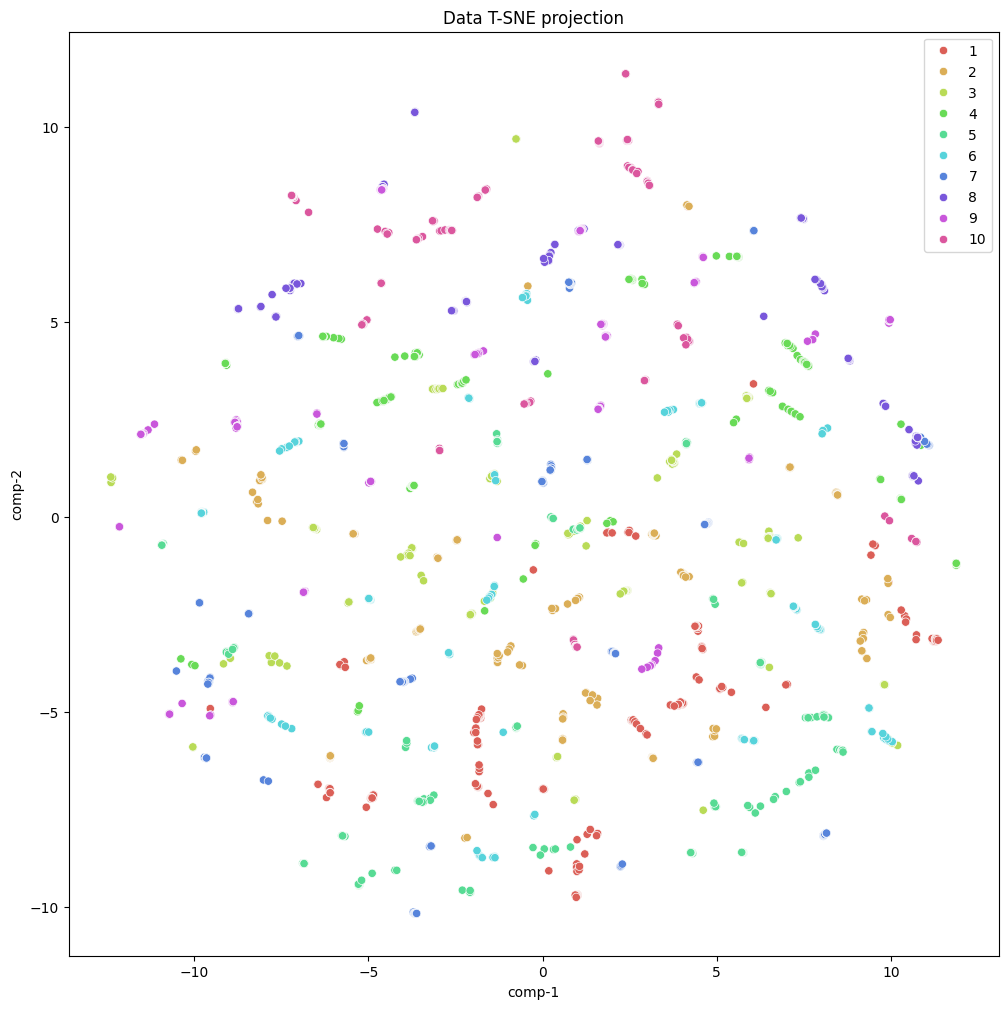

In [61]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300)
z = tsne.fit_transform(Y_train.transpose())
df = pd.DataFrame()
df["y"] = label_train
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
fig = plt.figure(figsize = (12, 12))
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", len(set(label_train))),
                data=df).set(title="Data T-SNE projection")

# Sparse Representation-based Classification (SRC)

In [62]:
# Run SRC
# !python run_SRC.py

## Compute dictionary as the straightforward concatenation of features vector from images

In [63]:
src = SRC.SRC(lamb=0.99999975)  # Sparsity regularizer in the underlying lasso minimization problem. The optimal value can be very different for different applications and paramenters.
src.fit(Y_train, label_train)

print(f'Num Classes: {src.num_classes}')
print(f'Feature vector dimension: {src.D.shape[0]}')
print(f'Atoms in dictionary: {src.D.shape[1]}')

Num Classes: 10
Feature vector dimension: 1500
Atoms in dictionary: 2000


## Image Classification using SRC on test data

In [64]:
start = time.time()
pred = src.predict(Y_test, iterations=100, mean_spars=True)
end = time.time()

print(f'Elapse time for prediction(s): {end - start}')
acc = np.sum(pred == label_test) / float(len(label_test))
print('Accuracy = {:.2f} %'.format(100 * acc))

/home/dfc/projects/classes/bdivs/lab6/data/DICTOL_python/dictol/SRC.py:30: RuntimeWarning: invalid value encountered in divide
  cs_bin = cs/cs[-1,:] > threshold


Mean sparsity: 10.48911111111111 out of 2000
Std sparsity: 8.8828419682047
Elapse time for prediction(s): 36.42728567123413
Accuracy = 95.06 %


In [65]:
# Class names from prediction
if le:
  class_id = le.inverse_transform(np.asarray(label_test)-1)
  class_pred = le.inverse_transform(pred-1)
  print(f'Actual ids for the first five test samples: {class_id[0:5]}')
  print(f'Id predictions for the first five test samples: {class_pred[0:5]}')

Actual ids for the first five test samples: ['01_palm' '01_palm' '01_palm' '01_palm' '01_palm']
Id predictions for the first five test samples: ['01_palm' '01_palm' '01_palm' '01_palm' '01_palm']


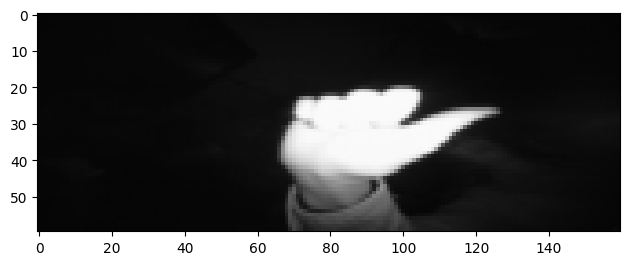

Actual id: 05_thumb
Predicted id: ['05_thumb']


In [66]:
# Prediction over a specific image
im_path = 'DICTOL_python/dictol/data/Hand Gesture Recognition Database/05_thumb/frame_00_05_0008.png'
if rp:
    # Computes feature vector (RP) from image
    im = imread(im_path)                          # Read image
    im = rescale(im, scale_factor)
    io.imshow(im)
    plt.show()
    im = (im/255)-0.5
    im_vec = im.reshape((1, -1))                  # To vector
    rp_feat = np.asarray(rp.compute_rp(im_vec)).transpose()

    # Estimate label from folder name
    full_path = os.path.dirname(im_path)
    label = os.path.normpath(full_path).split(os.path.sep)[-1]
    print(f'Actual id: {label}')
    pred_one = src.predict(rp_feat, iterations=100)
    print(f'Predicted id: {le.inverse_transform(pred_one-1)}')



# Dictionary learning with structured incoherence (DLSI)

In [67]:
# Run DLSI
#!python run_DLSI.py

## Learn a dictionary from the training features vector obtained from images

In [ ]:
# lamda: Sparsity regularizer in the underlying lasso minimization problem.
# k: number of atoms per class in the dictionary
dlsi = DLSI.DLSI(k=32, lambd=0.0000001, eta=0.001)
start = time.time()
dlsi.fit(Y_train, label_train, iterations=100, verbose=True)
end = time.time()

print(f'Elapse time for dictionary learning(s): {end - start}')
print(f'Num Classes: {dlsi.num_classes}')
print(f'Feature vector dimension: {src.D.shape[0]}')
print(f'Atoms in dictionary: {dlsi.D.shape[1]}')

## Image Classification using DLSI on test data

In [69]:
start = time.time()
pred = dlsi.predict(Y_test, iterations=100, mean_spars=True)
end = time.time()

print(f'Elapse time for prediction(s): {end - start}')
acc = np.sum(pred == label_test) / float(len(label_test))
print('Accuracy = {:.2f} %'.format(100 * acc))

Mean sparsity: 28.0 out of 320
Std sparsity: 0.0
Elapse time for prediction(s): 18.259403944015503
Accuracy = 10.00 %


In [70]:
# Class names from prediction
if le:
  class_id = le.inverse_transform(np.asarray(label_test)-1)
  class_pred = le.inverse_transform(pred-1)
  print(f'Actual ids for the first five test samples: {class_id[0:5]}')
  print(f'Id predictions for the first five test samples: {class_pred[0:5]}')



Actual ids for the first five test samples: ['01_palm' '01_palm' '01_palm' '01_palm' '01_palm']
Id predictions for the first five test samples: ['10_down' '10_down' '10_down' '10_down' '10_down']


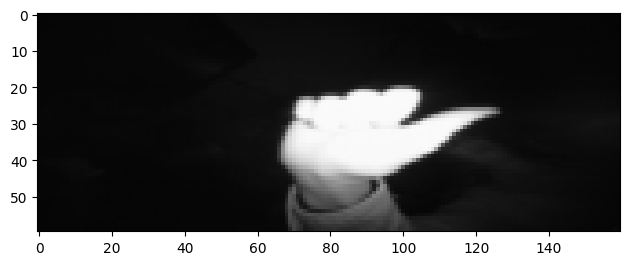

Actual id: 05_thumb
Predicted id: ['05_thumb']


In [71]:
# Prediction over a specific image
im_path = 'DICTOL_python/dictol/data/Hand Gesture Recognition Database/05_thumb/frame_00_05_0008.png'
if rp:
    # Computes feature vector (RFF) from image
    im = imread(im_path)                          # Read image
    im = rescale(im, scale_factor)
    io.imshow(im)
    plt.show()
    im = (im/255)-0.5
    im_vec = im.reshape((1, -1))                  # To vector
    rp_feat = np.asarray(rp.compute_rp(im_vec)).transpose()

    # Estimate label from folder name
    full_path = os.path.dirname(im_path)
    label = os.path.normpath(full_path).split(os.path.sep)[-1]
    print(f'Actual id: {label}')
    pred_one = dlsi.predict(rp_feat, iterations=100)
    print(f'Predicted id: {le.inverse_transform(pred_one-1)}')